## Run_QLC_FT

This code solves the QLC problem in Fourier space. Parameters include:
- $\overline N$, and $N^*$ (atomistic-level characteristics of the ice QLL thicknesses)
- $\sigma_o$ (difference in equilibrium supersaturation between microsurfaces I and II)
- $h_{pr}$ (thickness of a prismatic facet monolayer)
- $D_{surf}$ (surface diffusion coefficient of the QLL)
- $\nu_{kin}$ (kinetic velocity -- the rate at which water vapor strikes the surface)
- $L$ (physical length of the facet surface)
- $nx_{crystal}$ (number of discrete points used to represent the surface)
- $L$ (crystal dimension)
- $\sigma_{I,corner}$ (imposed supersaturation at the facet corner)
- $c_r$ (relative reduction in supersaturation at facet centers relative to corners, in fraction and %)
- $\tau_{eq}$ (time constant for ice/QLL freezing/thawing)

In [1]:
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
import numpy as np
from copy import copy as cp
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
from numba import njit, float64, int32, types
from matplotlib import rcParams
from time import time
from scipy.fft import fft, ifft, rfft, irfft, fftfreq
from scipy.signal import unit_impulse

import sys
sys.path.append('..')
import QLCstuff as QLC
import f90nml

In [2]:
%matplotlib inline
ticklabelsize = 15
linewidth = 1
fontsize = 15
titlefontsize = 8
markersize = 10

### Getting parameters for this run

In [3]:
inputfile = "GI parameters - Reference limit cycle (for testing).nml"

# For readability ...
print('Using parameter file '+inputfile+' ...')

print('\nFrom the GrowthInstability (GI) namelist:')
GI=f90nml.read(inputfile)['GI'] # Read the main parameter namelist

# Supersaturation at the corner of a facet
sigmaI_corner = GI['sigmaI_corner']
sigmaI_corner_units = GI['sigmaI_corner_units']
sigmaI_corner = AssignQuantity(sigmaI_corner,sigmaI_corner_units)
print('sigmaI_corner =', sigmaI_corner)

# Difference in equilibrium supersaturation between microsurfaces I and II
sigma0 = GI['sigma0']
sigma0_units = GI['sigma0_units']
sigma0 = AssignQuantity(sigma0,sigma0_units)
print('sigma0 =',sigma0)

# Reduction of supersaturation at the facet cental
c_r = GI['c_r']
c_r_units = GI['c_r_units']
c_r = AssignQuantity(c_r,c_r_units)
print('c_r =',c_r)

# Properties of the QLL
Nbar = GI['Nbar']; print('Nbar', Nbar)
Nstar = GI['Nstar']; print('Nstar', Nstar)

# Thickness of monolayers
h_pr = GI['h_pr']
h_pr_units = GI['h_pr_units']
h_pr = AssignQuantity(h_pr,h_pr_units) 
print('h_pr =', h_pr)

# Diffusion coeficient
D = GI['D']
D_units = GI['D_units']
D = AssignQuantity(D,D_units)
print('D =', D)

# Deposition velocity
nu_kin = GI['nu_kin']
nu_kin_units = GI['nu_kin_units']
nu_kin = AssignQuantity(nu_kin,nu_kin_units)
print('nu_kin =', nu_kin)

# Size of the facet
L = GI['L']
L_units = GI['L_units']
L = AssignQuantity(L,L_units)
print('L =', L)

# Crystal size -- needs to be an even number
nx_crystal = GI['nx_crystal']
print('nx (crystal) =', nx_crystal)

# Time constant for freezing/thawing
tau_eq = GI['tau_eq']
tau_eq_units = GI['tau_eq_units']
tau_eq = AssignQuantity(tau_eq,tau_eq_units)
print('tau_eq =',tau_eq)

# Integration algorithm (possibilities: RK45, BDF, RK23, DOP853, LSODA, and Radau)
odemethod = GI['odemethod']
print('odemethod =',odemethod)

Using parameter file GI parameters - Reference limit cycle (for testing).nml ...

From the GrowthInstability (GI) namelist:
sigmaI_corner = 0.23 dimensionless
sigma0 = 0.2 dimensionless
c_r = 0.005 dimensionless
Nbar 1
Nstar 0.1
h_pr = 0.389 nanometer
D = 0.000365 micrometer ** 2 / microsecond
nu_kin = 70 micrometer / second
L = 30 micrometer
nx (crystal) = 320
tau_eq = 5 microsecond
odemethod = RK45


In [4]:
# Conversions (in case inputs are in other units)
sigma0.ito('dimensionless')
h_pr.ito('micrometer')
D.ito('micrometer^2/microsecond')
nu_kin.ito('micrometer/second')
L.ito('micrometer')
sigmaI_corner.ito('dimensionless')
c_r.ito('dimensionless')
tau_eq.ito('microsecond')

### Varibles that depend on the above

In [5]:
x_QLC = np.linspace(-L,L,nx_crystal)
deltax = x_QLC[1]-x_QLC[0]
print('Spacing of points on the ice surface =', deltax)
sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)
nu_kin_mlyperus = nu_kin/h_pr
nu_kin_mlyperus.ito('1/microsecond')
Doverdeltax2 = D/deltax**2

Spacing of points on the ice surface = 0.18808777429467227 micrometer


### Runtime parameters from the namelist 

In [6]:
RT=f90nml.read(inputfile)['RT'] # Read the main parameter namelist

# How long
runtime = RT['runtime']
runtime_units = RT['runtime_units']
runtime = AssignQuantity(runtime,runtime_units)
print('runtime =', runtime)
runtime.ito('microsecond')

# Number of time steps to keep for reporting later
ntimes = RT['ntimes']

# Flag if we want more output
verbose = RT['verbose']

# Specify the time interval and initial conditions
tkeep_1Darr = np.linspace(0,runtime,ntimes)
Ntot_init_1D = np.ones(nx_crystal)
NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)

print('This is a run from time', tkeep_1Darr[0].to('msec'),'to', tkeep_1Darr[-1].to('msec'))
print('dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

runtime = 50 millisecond
This is a run from time 0.0 millisecond to 50.0 millisecond
dt = 1020.4081632653061 microsecond


### Run the scenario in Cartesian space (invoking the local version of run_f1d here)

10 % elapsed time is 0.025 minutes
20 % elapsed time is 0.044 minutes
30 % elapsed time is 0.065 minutes
40 % elapsed time is 0.084 minutes
50 % elapsed time is 0.105 minutes
60 % elapsed time is 0.125 minutes
70 % elapsed time is 0.146 minutes
80 % elapsed time is 0.166 minutes
90 % elapsed time is 0.186 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success', 't', 't_events', 'y', 'y_events']


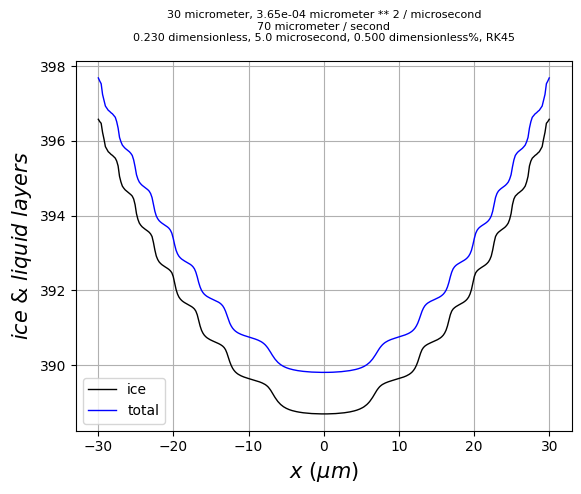

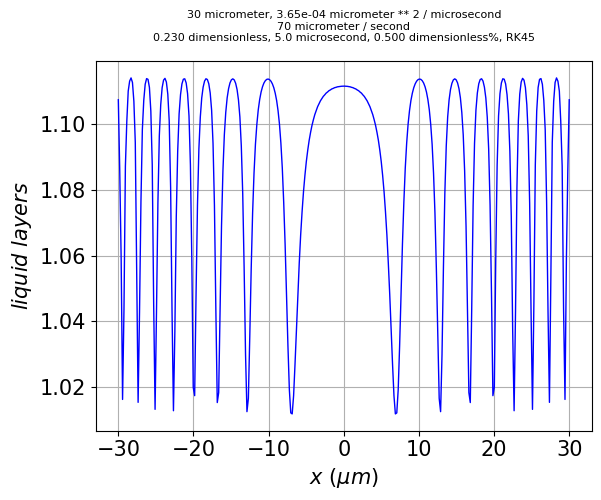

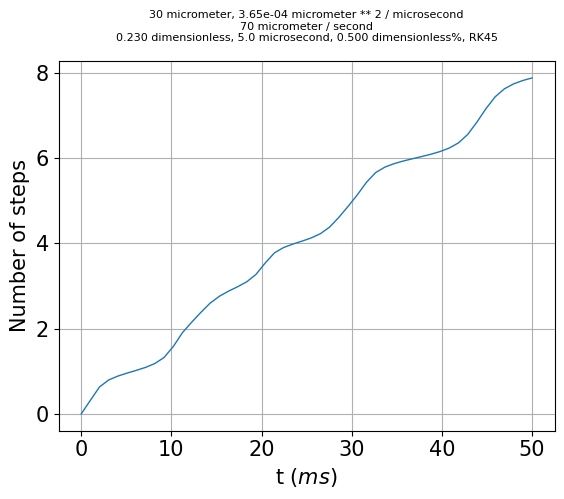

In [7]:
Ntotkeep_1D, NQLLkeep_1D = QLC.run_f1d(\
           NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
           Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,\
           AssignQuantity,\
           verbose=0, odemethod='RK45')
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

# Reporting and graphing
# Label for graphs
title_params = \
        "{:.0f}".format(L.magnitude)+' '+str(L.units)+\
        ", "+np.format_float_scientific(D.magnitude,precision=2)+" "+str(D.units)+\
        "\n"+\
        "{:.0f}".format(nu_kin.magnitude)+' '+str(nu_kin.units)+\
        "\n"+\
        "{:.3f}".format(sigmaI_corner.magnitude)+' '+str(sigmaI_corner.units)+\
        ", "+"{:.1f}".format(tau_eq.magnitude)+' '+str(tau_eq.units)+\
        ", "+"{:.3f}".format(c_r * 100)+'%'+\
        ", "+odemethod+\
        "\n"
    
g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,h_pr, \
        graphics=True,title_params=title_params)

### Run the scenario in FT space for comparison

In [8]:
# This is our sandbox for developing an FT equivalent of run_f1d

def run_f1d_FT(\
           NQLL_init_1D,Ntot_init_1D,times,\
           Nbar, Nstar, sigma0, nu_kin_mlyperus, DoverL2pi2, tau_eq, sigmaI,\
           AssignQuantity,\
           verbose=0, odemethod='RK45'):

    """ Solves the QLC problem, with units, in Fourier space """

    # Prep for the integration
    nt = len(times)
    lastprogress = 0
    sigmaI_mag = sigmaI.magnitude
    t1 = time()
    
    # This is to get j2_list because it's more efficient to pre-calculate it (but we'll use bj_list later too)
    bj_list = rfft(NQLL_init_1D)
    n_list = len(bj_list)
    j_list = np.array([j for j in range(n_list)])
    j2_list = np.array(j_list)**2
    l = int(len(NQLL_init_1D)/2)
    cos_series = 1
    for i in range(len(NQLL_init_1D) - 1):
        cos_series += np.cos((i + 1) * j_list * np.pi / l)

    # Bundle parameters for ODE solver
    scalar_params = np.array([Nbar, Nstar, sigma0.magnitude, nu_kin_mlyperus.magnitude, DoverL2pi2.magnitude, tau_eq.magnitude])

    # Package up the dynamical variables as FT 
    aj_list = rfft(Ntot_init_1D)
    Ylast = np.array([bj_list,aj_list])
    Ylast = np.reshape(Ylast,2*n_list)
    Ykeep_1D = [Ylast]
        
    # Loop over times
    for i in range(0,nt-1):
                
        # Specify the time interval of this step
        tinterval = [times[i].magnitude,times[i+1].magnitude]
        
        # Integrate up to next time step
        sol = solve_ivp(\
            f1d_solve_ivp_FT, tinterval, Ylast, args=(scalar_params, sigmaI.magnitude, j2_list, cos_series), \
            rtol=1e-12, method=odemethod) 
        Ylast = sol.y[:,-1]
        
        # Stuff into keeper arrays
        Ykeep_1D.append(Ylast)
        
        # Progress reporting
        progress = int(i/nt*100)
        if np.mod(progress,10) == 0:
            if progress > lastprogress:
                t2 = time()
                elapsed = (t2 - t1)/60
                print(progress,'%'+' elapsed time is %.3f minutes' %elapsed)
                lastprogress = progress

    print('100% done')
    print('status = ', sol.status)
    print('message = ', sol.message)
    print(dir(sol))
    
    # Packaging up the dynamical variables over time
    Ykeep_1Darr = np.array(Ykeep_1D, dtype=np.complex_)
    Ykeep_1Darr_reshaped = np.reshape(Ykeep_1Darr,(nt,2,n_list))
    Ykeep_Ntot_1D = Ykeep_1Darr_reshaped[:,1,:]
    Ykeep_NQLL_1D = Ykeep_1Darr_reshaped[:,0,:]
    
    # Convert to Cartesian values
    Ntotkeep_1D = irfft(Ykeep_Ntot_1D)
    NQLLkeep_1D = irfft(Ykeep_NQLL_1D)
    
    # Return the Cartesian values    
    return Ntotkeep_1D, NQLLkeep_1D


def f1d_solve_ivp_FT(t, Y, scalar_params, sigmaI, j2_list, cos_series):

    # Unpack parameters
    Nbar, Nstar, sigma0, nu_kin_mlyperus, Dcoefficient1, tau_eq = scalar_params
    l = int(len(Y)/2)

    # Extract the dynamical variables
    bj_list = Y[:l]
    aj_list = Y[l:]

    # Start with the diffusion term for Ntot
    cj_list = bj_list*j2_list
    daj_list_dt = -Dcoefficient1 * cj_list
    
    # Add in the deposition term (awkwardly done by reverse/forward FT -- this can be done more efficiently in FT) OLD
    NQLL0 = irfft(bj_list)
    #m = (NQLL0 - (Nbar - Nstar))/(2*Nstar)
    #sigma_m = (sigmaI - m * sigma0)
    #deposition_term = nu_kin_mlyperus * sigma_m
    #Deposition_term = rfft(deposition_term)
    #daj_list_dt += Deposition_term
    
    m_FT = (bj_list - (Nbar - Nstar) * cos_series) / (2 * Nstar)
    m = irfft(m_FT)
    sigma_m = (sigmaI - m * sigma0)
    deposition_term = nu_kin_mlyperus * sigma_m
    Deposition_term = rfft(deposition_term)
    daj_list_dt += Deposition_term

    # Freezing/melting for NQLL (awkwardly done by reverse/forward FT -- but we may be stuck with this 
    Ntot0 = irfft(aj_list)
    deltaNQLL = QLC.getDeltaNQLL(Ntot0,Nstar,Nbar,NQLL0)
    DeltaNQLL = rfft(deltaNQLL)
    dbj_list_dt = daj_list_dt - DeltaNQLL/tau_eq

    # Package up and return
    derivs = np.empty(2*l,dtype=np.complex_)
    derivs[:l] = dbj_list_dt
    derivs[l:] = daj_list_dt
    return derivs

In [9]:
DoverL2pi2 = D/L**2*np.pi**2

Ntotkeep_1D_FT, NQLLkeep_1D_FT = run_f1d_FT(\
           NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
           Nbar, Nstar, sigma0, nu_kin_mlyperus, DoverL2pi2, tau_eq, sigmaI_QLC,\
           AssignQuantity,\
           verbose=0, odemethod='RK45')
Nicekeep_1D_FT = Ntotkeep_1D_FT-NQLLkeep_1D_FT

10 % elapsed time is 0.061 minutes
20 % elapsed time is 0.114 minutes
30 % elapsed time is 0.168 minutes
40 % elapsed time is 0.220 minutes
50 % elapsed time is 0.275 minutes
60 % elapsed time is 0.327 minutes
70 % elapsed time is 0.383 minutes
80 % elapsed time is 0.435 minutes
90 % elapsed time is 0.487 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success', 't', 't_events', 'y', 'y_events']


Text(0.5, 1.0, 'asymmetry in Ntot')

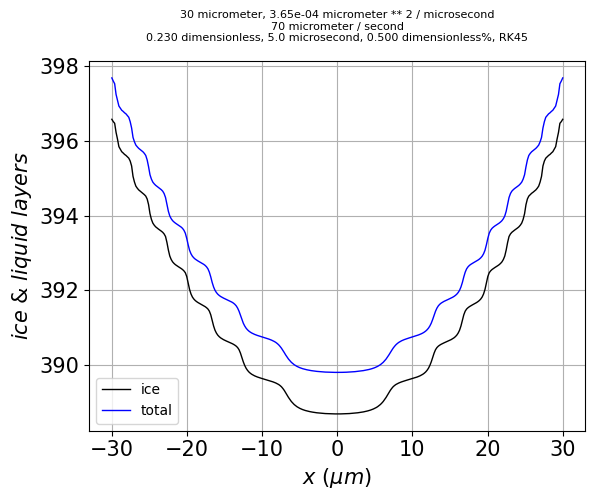

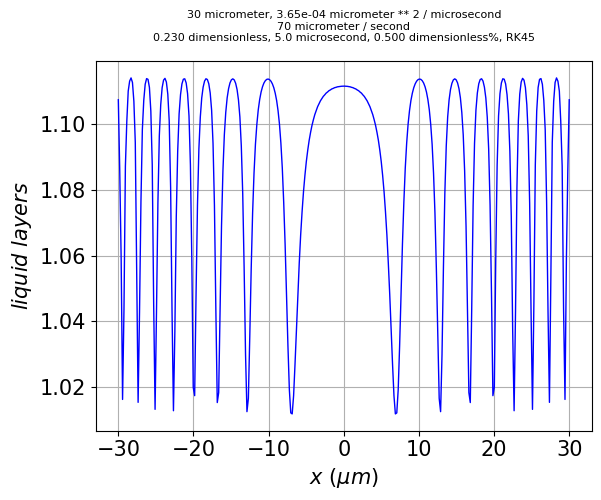

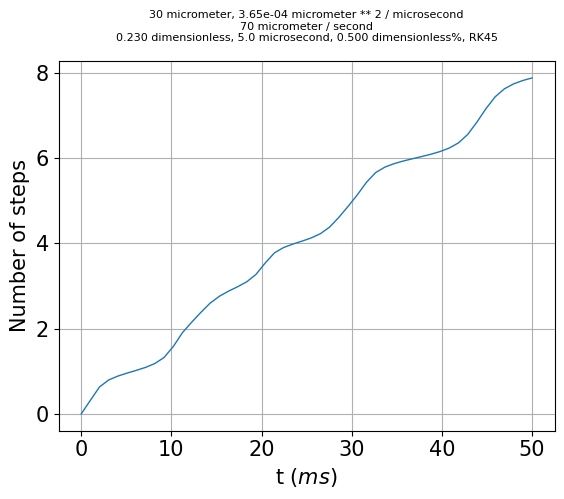

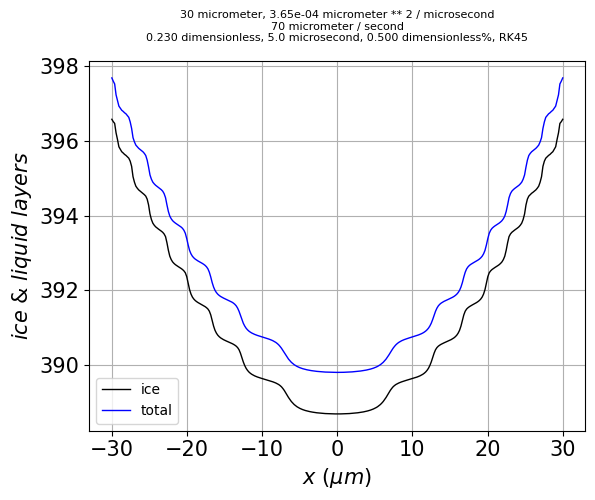

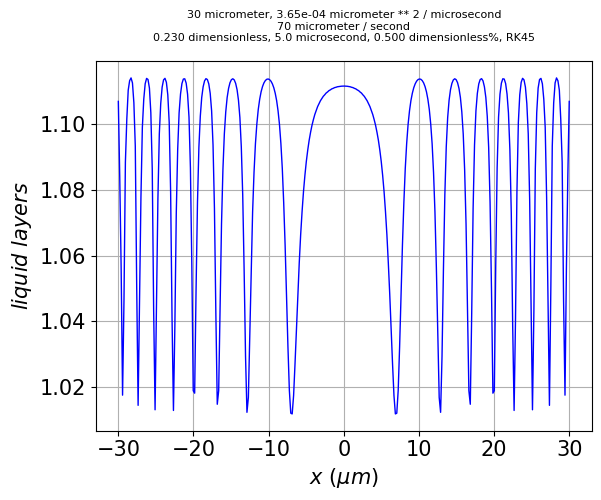

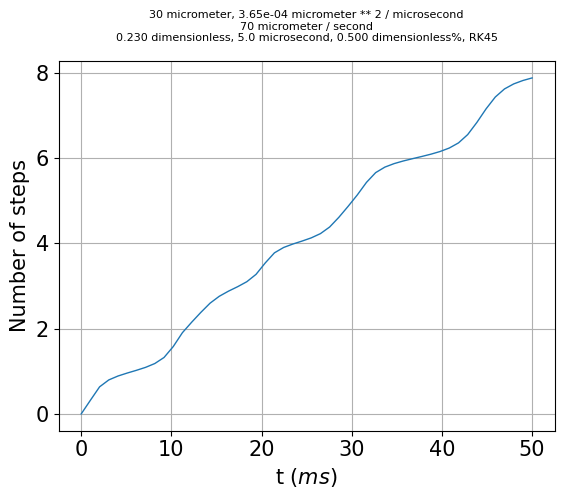

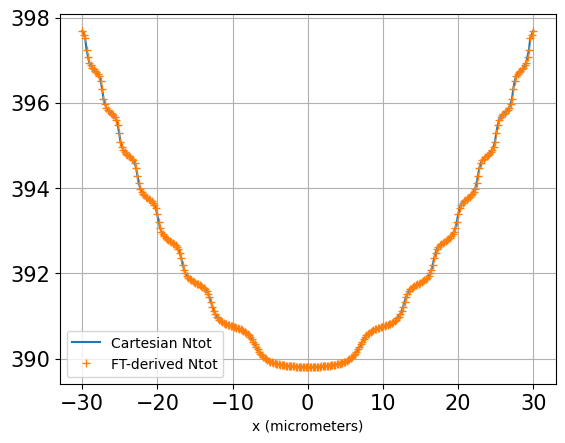

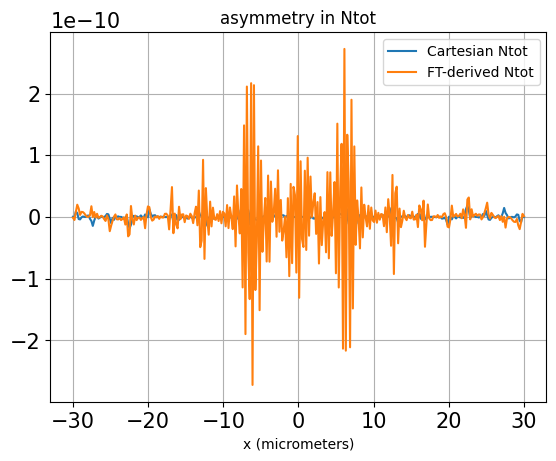

In [10]:
# Reporting
g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,h_pr, \
        graphics=True,title_params=title_params)

g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D_FT,Ntotkeep_1D_FT,Nicekeep_1D_FT,h_pr, \
        graphics=True,title_params=title_params)

plt.figure()
plt.plot(x_QLC.magnitude,Ntotkeep_1D[-1],label='Cartesian Ntot')
plt.plot(x_QLC.magnitude,Ntotkeep_1D_FT[-1],'+',label='FT-derived Ntot')
plt.xlabel('x (micrometers)')
plt.grid(True)
plt.legend()

difference_orig = Ntotkeep_1D[-1]-np.flip(Ntotkeep_1D[-1])
difference_FT = Ntotkeep_1D_FT[-1]-np.flip(Ntotkeep_1D_FT[-1])
plt.figure()
plt.plot(x_QLC.magnitude,difference_orig,label='Cartesian Ntot')
plt.plot(x_QLC.magnitude,difference_FT,label='FT-derived Ntot')
plt.xlabel('x (micrometers)')
plt.grid(True)
plt.legend()
plt.title('asymmetry in Ntot')

[ 8.50430837e-14 -7.91589017e-14  5.66213743e-15  5.51780843e-14
  8.32667268e-15 -2.67563749e-14 -5.88418203e-14  8.41549053e-14
 -4.13002965e-14  3.77475828e-15  1.99840144e-14 -1.11022302e-14
 -1.32005518e-13  1.34892097e-13 -8.20454815e-14  3.65263375e-14
  4.49640325e-14 -1.65423231e-14  6.90558721e-14 -1.09245946e-13
  6.26165786e-14 -3.08642001e-14  3.93018951e-14 -3.93018951e-14
 -3.51940699e-14 -1.74305015e-14  2.55351296e-14  4.17443857e-14
 -3.67483821e-14  2.14273044e-14  6.41708908e-14  8.43769499e-15
 -4.48530102e-14 -5.86197757e-14 -1.77635684e-14  5.68434189e-14
 -2.44249065e-15 -2.67563749e-14  8.80406859e-14 -3.73034936e-14
 -3.99680289e-15  4.62963001e-14  2.44249065e-14 -1.29229960e-13
  4.79616347e-14 -1.97619698e-14  4.77395901e-14 -8.14903700e-14
  1.70974346e-14  9.34807787e-14 -3.97459843e-14  2.69784195e-14
 -6.40598685e-14  4.99600361e-15 -2.09832152e-14 -5.88418203e-15
  1.08024700e-13 -1.36668454e-13  4.50750548e-14  4.86277685e-14
 -1.13242749e-14  1.31006

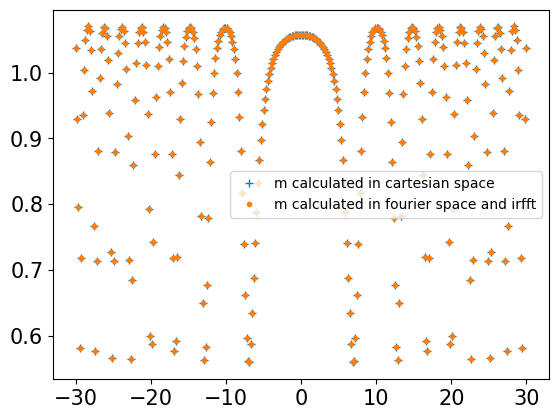

In [13]:
#work for coming up with cos series solution

NQLL0 = NQLLkeep_1D[-1]
bj_list = rfft(NQLL0)
n_list = len(bj_list)
j_list = np.array([j for j in range(n_list)])
j2_list = np.array(j_list)**2
l = int(len(NQLL0)/2)

m = (NQLL0 - (Nbar - Nstar))/(2*Nstar) #calc m normally

series = (Nbar - Nstar)/(2*Nstar)

for i in range(len(NQLL0) - 1):
    series += 1 * (Nbar - Nstar)/(2*Nstar) * np.cos((i + 1) * j_list * np.pi / l)

m_FT = (bj_list) / (2 * Nstar) #calc m in Fourier Space using bj_list
m_FT2 = (bj_list) / (2 * Nstar) - 4.5 - 9 * np.cos(j_list * np.pi / l) - 9 * np.cos(2 * j_list * np.pi / l) - 9 * np.cos(3 * j_list * np.pi / l) #calc m in Fourier Space using bj_list
m_FT3 = (bj_list) / (2 * Nstar) - series
m_IFT = irfft(m_FT)
m_IFT2 = irfft(m_FT2)
m_IFT3 = irfft(m_FT3)

print(m - m_IFT3)

plt.Figure()
plt.plot(x_QLC.magnitude,m,'+',label='m calculated in cartesian space')
plt.plot(x_QLC.magnitude,m_IFT3,'.',label='m calculated in fourier space and irfft')
plt.legend()